In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from C4_theo_asymptotique__trapz import C4_court, C4_long
from DoubleRigidWallOverdampedBrownExp_Cython import RigidWallOverdampedLangevin3D
from Physic_function_problem import *
import cythonised_simu_part

from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from mpltools import annotation
from scipy.optimize import curve_fit

import csv


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm


from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
    "font.size":8,
    'axes.titlesize':10,
    'axes.labelsize':10,
}
# sns.set_context("notebook", rc={"lines.linewidth": 3})


sns.set_theme(context = "paper", style="ticks", rc=custom_params)

In [103]:
# Param fixé comme expériences
a = 1.519e-6 #1.12e-6/2
H = 40e-6
lD = 88.0e-9 #Répultion mur
kBT=1.38e-23*300
lB = 526e-9 #gravité
B = 5.0
eta=0.001


dt = 1e-2
Nt = 10000000
Nt_sub = 1
tt = np.linspace(dt, dt*Nt, Nt)

In [62]:
simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, a=a, H=H, lD=lD, lB=lB, B=B, Nt_sub=Nt_sub)
#simu.trajectory()

# Calcul de $\frac{\mathrm{d}C4}{\mathrm{d}t}$

In [69]:
zz = np.linspace(-H, -H+20e-6, 1000000)

Dpara = D_para(zz, a, eta, H)
Peq = P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)
mean_Dpara_2 = np.trapz(Peq*D_para(zz, a, eta, H), zz) ** 2


In [109]:
def calcul(n):
    simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, a=a, H=H, lD=lD, lB=lB, B=B, Nt_sub=Nt_sub)
    simu.trajectory()
    dC4 = []
    
    for i in dt_C4:
        dX = simu.x[i:] - simu.x[:-i]
        D_para_z = D_para(simu.z[:-i], a, eta, H)

        dC4.append(12 * ( np.mean(dX ** 2 * D_para_z) -  2 * i*dt * mean_Dpara_2))
    
    return dC4

In [101]:
pool = multiprocessing.Pool()

In [105]:
def run_imap_unordered_multiprocessing(func, argument_list, num_processes):

    pool = Pool(processes=num_processes)

    result_list_tqdm = []
    for result in tqdm(pool.imap_unordered(func=func, iterable=argument_list), total=len(argument_list)):
        result_list_tqdm.append(result)

    return result_list_tqdm

In [110]:
## Lancement de simulations
result = run_imap_unordered_multiprocessing(calcul, list(range(1001)), 7)


100%|█████████████████████████████████████| 1001/1001 [4:14:39<00:00, 15.26s/it]


In [112]:
# result

In [126]:
## SAVE DATAS

# import pickle

# with open("DATA-simu_Ns1000.pkl","wb") as f:
#     pickle.dump(result, f)

In [114]:
# #all_s = []
# dt_C4 = [*np.arange(1, 10), *np.arange(10, 100, 10), *np.arange(100, 1000, 100), *np.arange(1000, 10000, 1000), 10000]


# for j in tqdm(range(1001)):
    
#     simu.trajectory()
#     dC4 = []
    
#     for i in dt_C4:
#         dX = simu.x[i:] - simu.x[:-i]
#         D_para_z = D_para(simu.z[:-i], a, eta, H)

#         dC4.append(12 * ( np.mean(dX ** 2 * D_para_z) -  2 * i*dt * mean_Dpara_2))
    
#     all_s.append(dC4)
    
#     if j%100 == 2:
#         with open("test_correct_D.pkl","wb") as f:
#             pickle.dump(all_s, f)

In [116]:
D4_theo = 1.2691e-27
A4_theo = C4_court(D=D_para, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-8)
A4_theo

2.335706168867776e-27

In [118]:
with open('DATA-simu_Ns1000.pkl', 'rb') as f:
    data = pickle.load(f)

In [119]:
data_s = np.array(data)
dt_C4 = [*np.arange(1, 10), *np.arange(10, 100, 10), *np.arange(100, 1000, 100), *np.arange(1000, 10000, 1000), 10000]
dt_s = np.array(dt_C4)*dt

In [121]:
# np.squeeze(all_s)

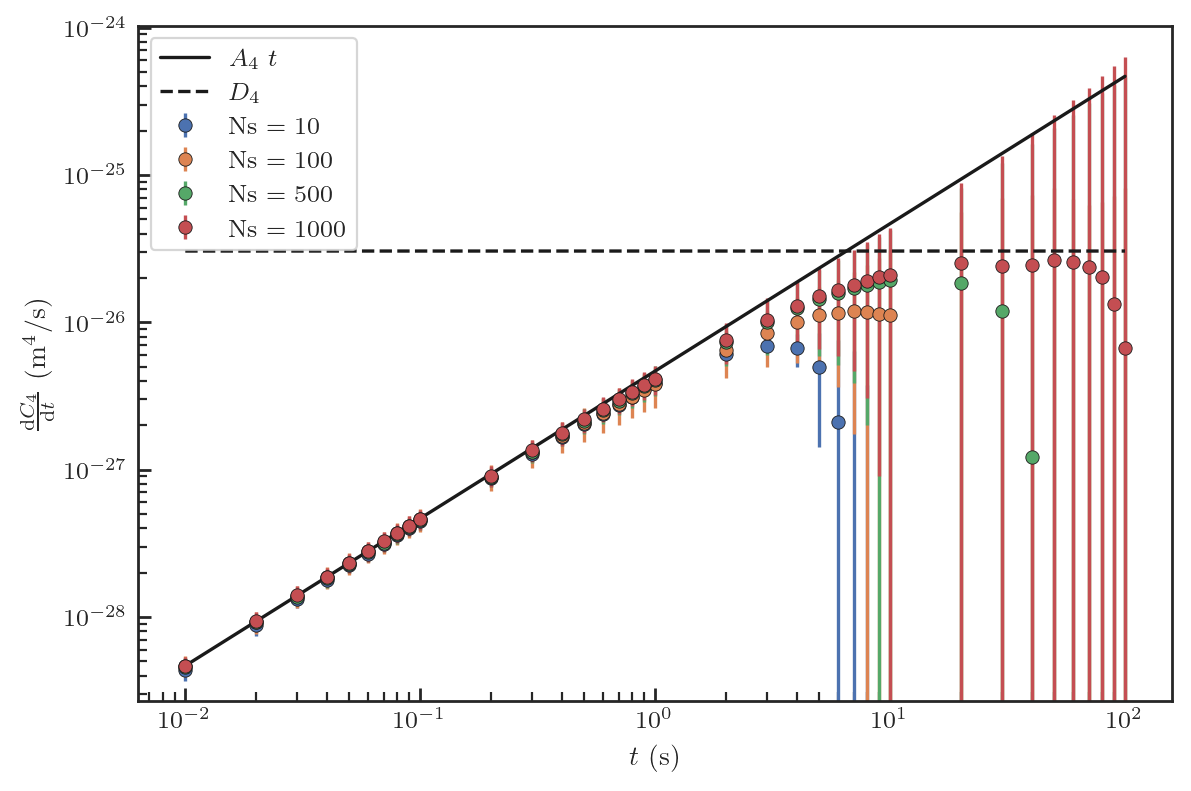

In [141]:
tt = np.array(list(range(1,10000,10)))
t_theo = np.linspace(1e-2, 100, 10000)

fig = plt.figure(tight_layout=True)  #figsize = (3.3, 3.3/1.68),  

simu = len(data_s[:,0])

ax1 = plt.subplot(111)
for s in [10, 100, 500, 1000]:
    ax1.errorbar(dt_s[:],  np.mean(data_s[:s,:], axis=0),yerr = np.std(data_s[:s,:], axis=0), fmt="o", label=r"Ns = "+str(s))


ax1.loglog(t_theo, A4_theo*2*t_theo, "k-", label=r"$A_4 ~t$" )
ax1.plot(t_theo, 24*D4_theo*np.ones(len(t_theo)), "k--", label=r"$D_4$")
ax1.set(
    xlabel = r"$t$ (s)",
    ylabel = r"$\frac{\mathrm{d}C_4}{\mathrm{d}t}$ $(\mathrm{m}^4/\mathrm{s})$",
)

# ax1.set_xlim(0,10)
# ax1.set_ylim(0,24*D4_theo)
ax1.legend()

# plt.savefig("Sur_la_note_de_DAVID/Convergence-dC4.png")